# Q3
Pseudocode:
1. Define functions for x and y components of acceleration as found in part a) for each particle.
2. Instantiate variables N = 1000 steps and h = 0.01 step size, as well as initial conditions for velocity components for each particle (in this case all 0). Let number of particles be an input parameter of the function we are defining. 
3. Definine initial conditions for position components as specified. In this case, evenly spaced in a grid of size sqrt of number of particles. 
4. Preallocate memory to an empty array of size number of particles by number of iterations by 2 to later store x and y components for position and velocity for each particle at each time step. 
5. Store initial conditions for velocity and position components in the 0th time index in their respective arrays for both x and y components.
8. Implement equations 8-11 component-wise from lab manual with acceleration components mentioned in step 1 as the components of $\vec{f}$ to prepare for iteration steps. 
8. In a for-loop from 1 to N update values for trajectory and velocity components according to the series of equations 8-11 in the lab manual (Verlet method) and store the values at each iteration in the appropriate array that we instantiated in step 4. Here we will be sure to take the components of $\vec{f}$ as the sum of the accelerations imparted by the other (number of particles - 1).


In [67]:
import numpy as np

In [68]:
def Potential(r):
    return 4*(r**(-12) - r**(-6))
def Kinetic(vx, vy):
    return 0.5*(vx**2 + vy**2)

In [69]:
# acceleration
def fx_ij(xi, xj, yi, yj):
    '''
    Function f_ij: Gives the x comp of acceleration experienced by particle i due to
    Lennard-Jones potential wrt particle j.  
    '''
    r = np.sqrt((xj- xi)**2 + (yj - yi)**2)  # separation distance
    return 24 * (xj - xi) * r**(-8) * (1 - 2 * r**(-6))
    
def fy_ij(xi, xj, yi, yj):
    '''
    Function f_ij: Gives the y comp of acceleration experienced by particle i due to
    Lennard-Jones potential wrt particle j.  
    '''
    r = np.sqrt((xj- xi)**2 + (yj - yi)**2)  # separation distance
    return 24 * (yj - yi) * r**(-8) * (1 - 2 * r**(-6))
    
def R(xi, xj, yi, yj):
    return np.sqrt((xj- xi)**2 + (yj - yi)**2)

In [93]:
def doVerlet(num_particles, periodic = False):
    '''
    Function: doVerlet: This function performs the Verlet algorithim 
    in order to calculate the position of two particles. 
    Input: num_particles an int indicating number of particles to model. periodic is
    a boolean flag to indicate implementation of periodic boundary conditions
    ''' 
    N = 1000 #number of iterations
    h = 0.01 #time step
    
    # Initial Conditions
    Lx = 4.0    # X component of momentum
    Ly = 4.0    # Y component of momentum
    dx = Lx/np.sqrt(num_particles)
    dy = Ly/np.sqrt(num_particles)
    x_grid = np.arange(dx/2, Lx, dx)
    y_grid = np.arange(dy/2, Ly, dy)
    xx_grid, yy_grid = np.meshgrid(x_grid, y_grid)
    x_initial = xx_grid.flatten()
    y_initial = yy_grid.flatten()
    
    #initial rest condition
    v_i = 0.0
    
    #preallocate memory for position velocity, v_prep (ie v(t+h/2))
    r = np.zeros([num_particles, N, 2])
    v = np.zeros([num_particles, N, 2])
    v_prep = np.zeros([num_particles,2])
    
    #set IC
    r[:,0,0] = x_initial
    r[:,0,1] = y_initial
    v[:,0,:] = v_i
    
    #eq 7
    #variables with _prep suffix get updated at each iteration and represent
    #v(t+h/2) in Verlet algorithm (eq 8 - 11) in lab manual
    
    #arrays for storing acceleration due to interaction from each particle
    fx = np.zeros(num_particles)
    fy = np.zeros(num_particles)
    if periodic: #use these to store replicated positions
        r1 = np.zeros([num_particles,2])
        r2 = np.zeros([num_particles,2])
        r3 = np.zeros([num_particles,2])
        r4 = np.zeros([num_particles,2])
        r5 = np.zeros([num_particles,2])
        r6 = np.zeros([num_particles,2])
        r7 = np.zeros([num_particles,2])
        r8 = np.zeros([num_particles,2])
    
    Energy = np.zeros(N)
    Pot = np.zeros(N)
    Kin = np.zeros(N)
    
    #let's get the first v_prep's using equation 7
    for i in range(num_particles):
        for j in range(num_particles):
            if j != i:
                #need to sum up the interactions on each particle from all the others
                fx[i] += fx_ij(r[i,0,0], r[j,0,0], r[i,0,1], r[j,0,1])
                fy[i] += fy_ij(r[i,0,0], r[j,0,0], r[i,0,1], r[j,0,1])
                
                Pot[0] += Potential(R(r[i,0,0], r[j,0,0], r[i,0,1], r[j,0,1]))
                
            if periodic: #need to add the interactions from the extra replicated particles
                #replicate positions and shift
                r1[:,0] = r[:,0,0] - Lx 
                r1[:,1] = r[:,0,1] + Ly
                r2[:,0] = r[:,0,0]
                r2[:,1] = r[:,0,1] + Ly
                r3[:,0] = r[:,0,0] + Lx
                r3[:,1] = r[:,0,1] + Ly
                r4[:,0] = r[:,0,0] - Lx
                r4[:,1] = r[:,0,1]
                r5[:,0] = r[:,0,0] + Lx
                r5[:,1] = r[:,0,1]
                r6[:,0] = r[:,0,0] - Lx
                r6[:,1] = r[:,0,1] - Ly
                r7[:,0] = r[:,0,0]
                r7[:,1] = r[:,0,1] - Ly
                r8[:,0] = r[:,0,0] + Lx
                r8[:,1] = r[:,0,1] - Ly
                #add on the interactions from the shifted replicated particles
                fx[i] += fx_ij(r[i,0,0], r1[j,0], r[i,0,1], r1[j,1])
                fy[i] += fy_ij(r[i,0,0], r1[j,0], r[i,0,1], r1[j,1])
                fx[i] += fx_ij(r[i,0,0], r2[j,0], r[i,0,1], r2[j,1])
                fy[i] += fy_ij(r[i,0,0], r2[j,0], r[i,0,1], r2[j,1])
                fx[i] += fx_ij(r[i,0,0], r3[j,0], r[i,0,1], r3[j,1])
                fy[i] += fy_ij(r[i,0,0], r3[j,0], r[i,0,1], r3[j,1])
                fx[i] += fx_ij(r[i,0,0], r4[j,0], r[i,0,1], r4[j,1])
                fy[i] += fy_ij(r[i,0,0], r4[j,0], r[i,0,1], r4[j,1])
                fx[i] += fx_ij(r[i,0,0], r5[j,0], r[i,0,1], r5[j,1])
                fy[i] += fy_ij(r[i,0,0], r5[j,0], r[i,0,1], r5[j,1])
                fx[i] += fx_ij(r[i,0,0], r6[j,0], r[i,0,1], r6[j,1])
                fy[i] += fy_ij(r[i,0,0], r6[j,0], r[i,0,1], r6[j,1])
                fx[i] += fx_ij(r[i,0,0], r7[j,0], r[i,0,1], r7[j,1])
                fy[i] += fy_ij(r[i,0,0], r7[j,0], r[i,0,1], r7[j,1])
                fx[i] += fx_ij(r[i,0,0], r8[j,0], r[i,0,1], r8[j,1])
                fy[i] += fy_ij(r[i,0,0], r8[j,0], r[i,0,1], r8[j,1])
  
        #kinetic energy
        Kin[0] += Kinetic(v[i, 0, 0], v[i, 0, 1])
        v_prep[i, 0] = v[i, 0, 0] + 0.5 * h * fx[i] 
        v_prep[i, 1] = v[i, 0, 1] + 0.5 * h * fy[i] 
    #total energy for t = 0
    Energy[0] = Kin[0] + Pot[0]/2 #divide by 2 to account for double counting
    
    #now that we've 'prepped' the system we can begin iterating
    
    
    #print(Kin[0], Pot[0], 'potential energy')
    for i in range(1,N):
        for j in range(num_particles): #need to update each particle at each time step 
            #eq 8
            r[j, i, 0] = r[j, i-1, 0] + h * v_prep[j, 0] #x
            r[j, i, 1] = r[j, i-1, 1] + h * v_prep[j, 1] #y
            if periodic: #take the positions modulus length of box
                r[j, i, 0] = np.mod(r[j, i, 0], Lx)
                r[j, i, 1] = np.mod(r[j, i, 1], Ly)
        for j in range(num_particles):
            #need to sum up the interactions on each particle from all the others
            fx = np.zeros(num_particles)
            fy = np.zeros(num_particles) 
            
            if periodic: #use these to store replicated positions
                r1 = np.zeros([num_particles,2])
                r2 = np.zeros([num_particles,2])
                r3 = np.zeros([num_particles,2])
                r4 = np.zeros([num_particles,2])
                r5 = np.zeros([num_particles,2])
                r6 = np.zeros([num_particles,2])
                r7 = np.zeros([num_particles,2])
                r8 = np.zeros([num_particles,2])
            for k in range(num_particles): 
                if k != j:
                    fx[j] += fx_ij(r[j,i,0], r[k,i,0], r[j,i,1], r[k,i,1])
                    fy[j] += fy_ij(r[j,i,0], r[k,i,0], r[j,i,1], r[k,i,1])
                    
                    Pot[i] += Potential(R(r[j,i,0], r[k,i,0], r[j,i,1], r[k,i,1]))
                    
                if periodic: #need to add the interactions from the extra replicated particles
                    #replicate positions and shit
                    r1[:,0] = r[:,i,0] - Lx 
                    r1[:,1] = r[:,i,1] + Ly
                    r2[:,0] = r[:,i,0]
                    r2[:,1] = r[:,i,1] + Ly
                    r3[:,0] = r[:,i,0] + Lx
                    r3[:,1] = r[:,i,1] + Ly
                    r4[:,0] = r[:,i,0] - Lx
                    r4[:,1] = r[:,i,1]
                    r5[:,0] = r[:,i,0] + Lx
                    r5[:,1] = r[:,i,1]
                    r6[:,0] = r[:,i,0] - Lx
                    r6[:,1] = r[:,i,1] - Ly
                    r7[:,0] = r[:,i,0]
                    r7[:,1] = r[:,i,1] - Ly
                    r8[:,0] = r[:,i,0] + Lx
                    r8[:,1] = r[:,i,1] - Ly
                    #add on interactions from replicated shifted particles
                    fx[j] += fx_ij(r[j,i,0], r1[j,0], r[j,i,1], r1[j,1])
                    fy[j] += fy_ij(r[j,i,0], r1[j,0], r[j,i,1], r1[j,1])
                    fx[j] += fx_ij(r[j,i,0], r2[j,0], r[j,i,1], r2[j,1])
                    fy[j] += fy_ij(r[j,i,0], r2[j,0], r[j,i,1], r2[j,1])
                    fx[j] += fx_ij(r[j,i,0], r3[j,0], r[j,i,1], r3[j,1])
                    fy[j] += fy_ij(r[j,i,0], r3[j,0], r[j,i,1], r3[j,1])
                    fx[j] += fx_ij(r[j,i,0], r4[j,0], r[j,i,1], r4[j,1])
                    fy[j] += fy_ij(r[j,i,0], r4[j,0], r[j,i,1], r4[j,1])
                    fx[j] += fx_ij(r[j,i,0], r5[j,0], r[j,i,1], r5[j,1])
                    fy[j] += fy_ij(r[j,i,0], r5[j,0], r[j,i,1], r5[j,1])
                    fx[j] += fx_ij(r[j,i,0], r6[j,0], r[j,i,1], r6[j,1])
                    fy[j] += fy_ij(r[j,i,0], r6[j,0], r[j,i,1], r6[j,1])
                    fx[j] += fx_ij(r[j,i,0], r7[j,0], r[j,i,1], r7[j,1])
                    fy[j] += fy_ij(r[j,i,0], r7[j,0], r[j,i,1], r7[j,1])
                    fx[j] += fx_ij(r[j,i,0], r8[j,0], r[j,i,1], r8[j,1])
                    fy[j] += fy_ij(r[j,i,0], r8[j,0], r[j,i,1], r8[j,1])
                    
            #eq 9 and 10 combined
            v[j, i, 0] = v_prep[j, 0] + 0.5 * h * fx[j]
            v[j, i, 1] = v_prep[j, 1] + 0.5 * h * fy[j] 
            #print(v[j,i,1], i, j)
            #eq 9 and 11 combined (getting v_prep's for next iteration)
            v_prep[j, 0] += h * fx[j]
            v_prep[j, 1] += h * fy[j]
        for j in range(num_particles):
            Kin[i] += Kinetic(v[j, i, 0], v[j, i, 1])

        #print(Kin[i], Pot[i])

        Energy[i] = Kin[i] + Pot[i]/2 #divide by 2 to account for double counting
        #print(Kin[i], Pot[i])
        #print(Energy[i])
    t = np.linspace(0,h*(N-1),N)
    return v, r, t, Energy, Kin, Pot

In [76]:
num_particles = 16
v, r, t, Energy, Kin, Pot = doVerlet(num_particles)

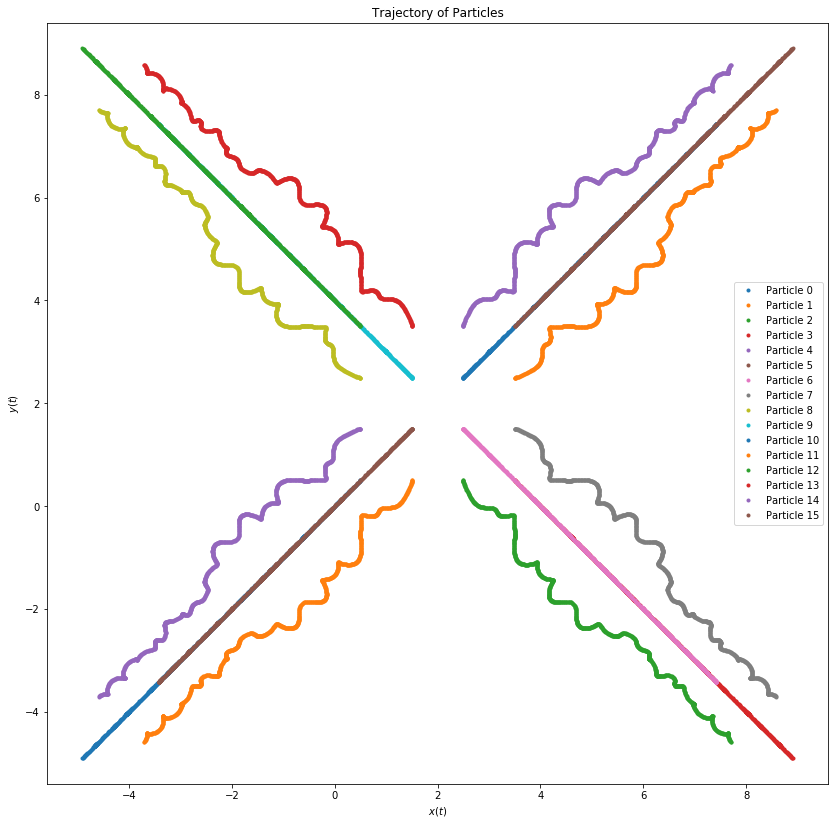

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize = (14,14))
plt.title('Trajectory of Particles')
plt.xlabel('$x(t)$')
plt.ylabel('$y(t)$')
for i in range(num_particles):
    lb = 'Particle '+str(i)
    plt.plot(r[i,:,0], r[i,:,1], '.', label = lb)
plt.legend()
plt.axis('equal')
plt.show()

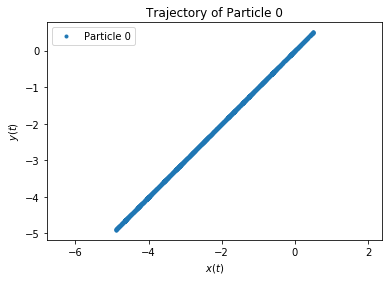

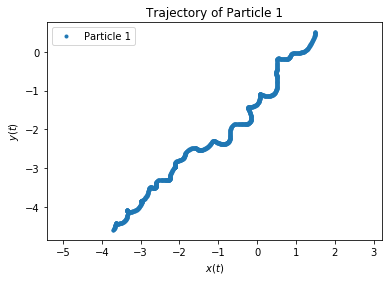

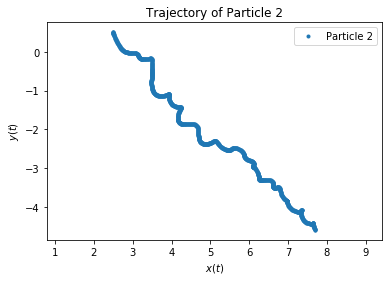

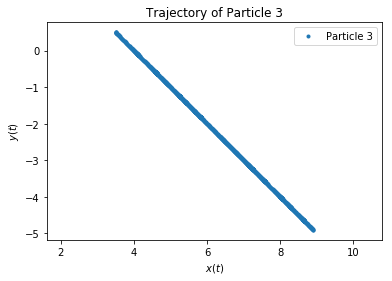

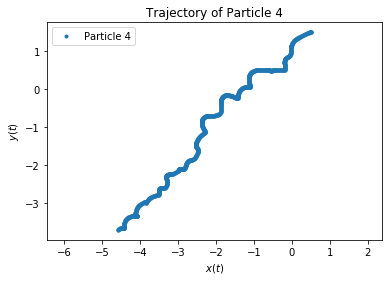

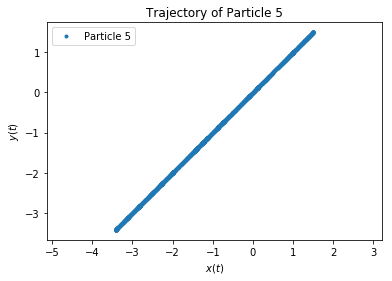

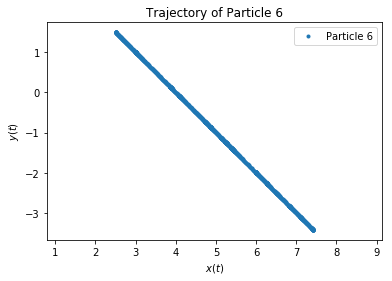

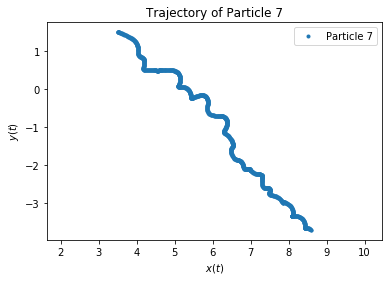

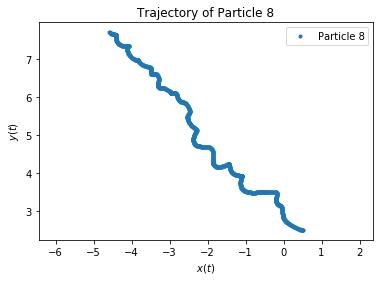

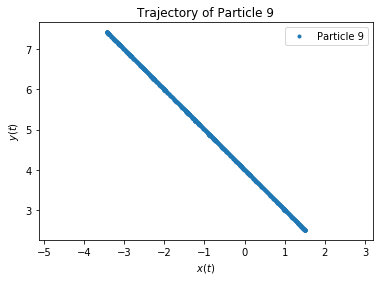

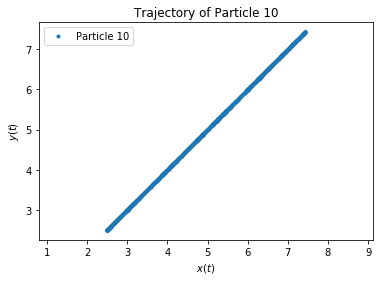

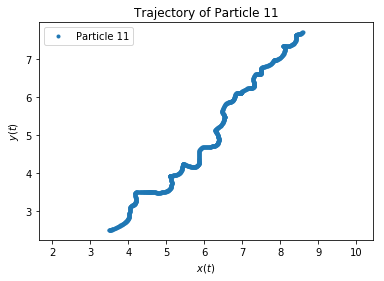

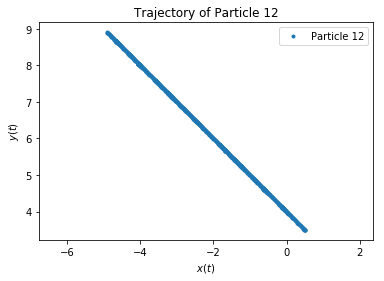

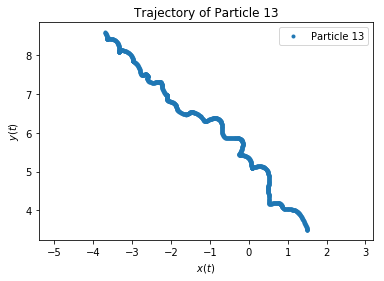

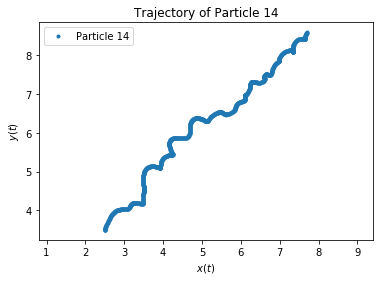

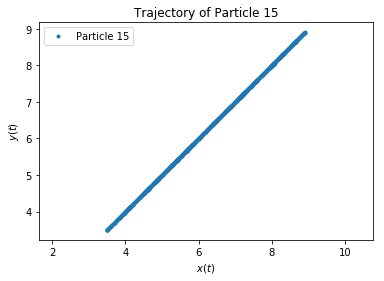

In [78]:
for i in range(num_particles):
    plt.figure()
    plt.title('Trajectory of Particle '+str(i))
    plt.xlabel('$x(t)$')
    plt.ylabel('$y(t)$')
    lb = 'Particle '+str(i)
    plt.plot(r[i,:,0], r[i,:,1], '.', label = lb)
    plt.legend()
    plt.axis('equal')
    plt.show()

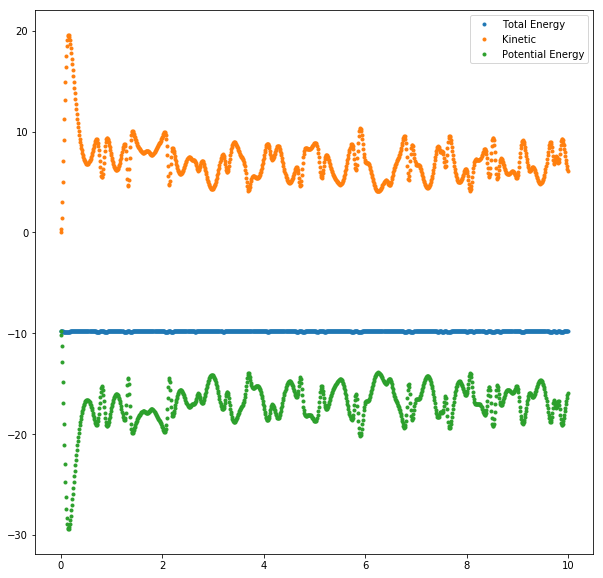

In [88]:
plt.figure(figsize = (10,10))
plt.plot(t, Energy, '.', label = 'Total Energy')
plt.plot(t, Kin, '.', label = 'Kinetic')
plt.plot(t, Pot/2, '.', label = 'Potential Energy')
plt.legend()

In [90]:
print(max(Energy),'max')
print(min(Energy),'min')
print(np.mean(Energy),'mean')
print(Energy[0],'inititial')
print(100*(max(Energy)- min(Energy))/Energy[0], '% difference')

-9.791326657246051 max
-9.850557787047798 min
-9.826178000871451 mean
-9.791326657246051 inititial
-0.604934672033568 % difference


In [94]:
vp, rp, tp, Energyp, Kinp, Potp = doVerlet(num_particles, periodic = True)

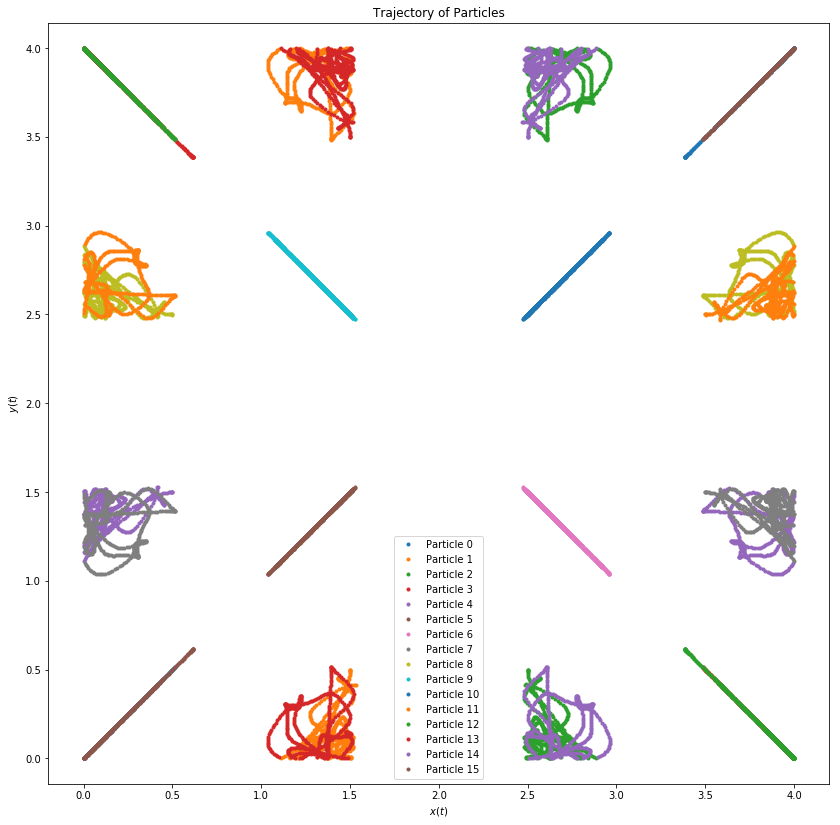

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize = (14,14))
plt.title('Trajectory of Particles')
plt.xlabel('$x(t)$')
plt.ylabel('$y(t)$')
for i in range(num_particles):
    lb = 'Particle '+str(i)
    plt.plot(rp[i,:,0], rp[i,:,1], '.', label = lb)
plt.legend()
plt.axis('equal')
plt.show()